In [1]:
import numpy as np
import pandas as pd
from typing import Optional, List, Dict, Callable, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [2]:
df = pd.read_csv("../data/gold_prices.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [3]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,1281.000000,1286.000000,1277.599976,1286.000000,149
2019-01-03,1291.800049,1292.000000,1286.699951,1286.800049,10
2019-01-04,1282.699951,1294.199951,1275.300049,1294.199951,34
2019-01-07,1286.800049,1286.800049,1286.599976,1286.800049,2
2019-01-08,1283.199951,1283.199951,1278.199951,1280.500000,54
...,...,...,...,...,...
2025-09-24,3732.100098,3772.500000,3732.100098,3769.800049,588
2025-09-25,3736.899902,3756.000000,3724.699951,3742.800049,1899
2025-09-26,3775.300049,3775.300049,3775.300049,3775.300049,19308


## CLS

In [4]:
class Backtester:
    """
    Backtesting class for testing trade strategy:
    - Long-only dip-buy with pyramiding to target leverage
    - Explicit liquidation using daily LOW (intraday approximation)

    Required inputs:
      - data (pd.DataFrame): must have columns ['Open','High','Low','Close'] and either a Date index or 'date' column
      - start_fund (float): starting equity/collateral
      - target_leverage (float): desired total leverage (Notional / Equity) to reach when adding
      - drop_trigger_pct (float): % drop from rolling ATH (based on daily HIGH) to trigger adds (e.g., 0.10 for 10%)
      - fee_pct (float): proportional fee applied to each add's notional (e.g., 0.0002 = 2 bps)
      - mmr (float): maintenance margin rate in (0, 1), e.g., 0.005 (0.5%)
      - buy_on_start (bool): if True, buy at the first day's OPEN to reach target leverage; if False, wait for dip trigger
      - print_daily (bool): if True, print daily updates (default: True)
      - buy_at (str): price to execute dip-buy, either 'close' (default) or 'trigger'.
        - 'trigger'-> buy at the trigger level price (dip threshold) when condition is met
        - 'close'  -> buy at the daily close when condition is met
      - start_date (str): optional start date for backtest (format: 'YYYY-MM-DD')
      - end_date (str): optional end date for backtest (format: 'YYYY-MM-DD')

    Notes on 'trigger' execution:
      - Trigger level is dip_level = (1 - drop_trigger_pct) * rolling_ath, where rolling_ath uses the day's HIGH.
      - When close <= dip_level, we approximate the execution price as the trigger level (within the day's [Low, High] range).

    Optional:
      - print_daily (bool): if True, print date | current Close price | equity | liquidation price each day (default: True)

    Liquidation model (cross-margin approximation):
      Equity E = start_fund - fees_paid_total + qty * (P - avg_entry)
      Notional N = qty * P
      Liquidate when: E <= mmr * N
      Solve for liquidation price P_liq:
        P_liq = (start_fund - fees_paid_total - qty * avg_entry) / ((mmr - 1) * qty)
      If day's LOW <= P_liq, trigger liquidation and STOP the backtest.

    Attributes available after run():
      - equity_curve (pd.Series): equity by date
      - unrealized_curve (pd.Series): unrealized PnL by date
      - position_qty (pd.Series): position size by date
      - position_avg_price (pd.Series): average entry price by date
      - unrealized_df (pd.DataFrame): one-column DF ('unrealized_pnl') with date index
      - max_drawdown_amount (float)
      - max_drawdown_pct (float)
      - final_fund (float)
      - trades (List[Dict]): logs of adds and liquidation (date, price, qty, notional, fee_paid, reason)
      - liquidation_event (Dict|None): details if liquidated (date, liq_price, equity_before, qty_before, avg_price)
    """

    def __init__(
        self,
        data: pd.DataFrame,
        start_fund: float,
        target_leverage: float,
        drop_trigger_pct: float,
        fee_pct: float,
        mmr: float = 0.005,
        buy_on_start: bool = True,
        print_daily: bool = True,
        buy_at: str = "trigger",
        start_date: str = None,
        end_date: str = None,
    ):
        # --- Validate & prepare data ---
        df = data.copy()
        # Accept 'date' column as index if present
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)

        if start_date is not None:
            df = df[df.index >= pd.to_datetime(start_date)]
        if end_date is not None:
            df = df[df.index <= pd.to_datetime(end_date)]

        # Enforce required title-cased OHLC columns
        required_cols = {'Open', 'High', 'Low', 'Close'}
        if not required_cols.issubset(df.columns):
            raise ValueError("DataFrame must have columns: 'Open','High','Low','Close'")

        df = df.sort_index()

        # --- Validate parameters ---
        if mmr <= 0 or mmr >= 1:
            raise ValueError("mmr must be between 0 and 1 (e.g., 0.005 = 0.5%)")
        if target_leverage <= 0:
            raise ValueError("target_leverage must be positive")
        if drop_trigger_pct <= 0 or drop_trigger_pct >= 1:
            raise ValueError("drop_trigger_pct must be in (0, 1), e.g., 0.10 for 10%")
        if fee_pct < 0:
            raise ValueError("fee_pct cannot be negative")
        if buy_at not in ("trigger", "close"):
            raise ValueError("buy_at must be either 'trigger' or 'close'")

        # --- Store inputs ---
        self.df = df
        self.start_fund = float(start_fund)
        self.target_leverage = float(target_leverage)
        self.drop_trigger_pct = float(drop_trigger_pct)
        self.fee_pct = float(fee_pct)
        self.mmr = float(mmr)
        self.buy_on_start = bool(buy_on_start)
        self.print_daily = bool(print_daily)
        self.buy_at = buy_at

        # --- Outputs (initialized) ---
        self.equity_curve: Optional[pd.Series] = None
        self.unrealized_curve: Optional[pd.Series] = None
        self.position_qty: Optional[pd.Series] = None
        self.position_avg_price: Optional[pd.Series] = None
        self.unrealized_df: Optional[pd.DataFrame] = None
        self.max_drawdown_amount: Optional[float] = None
        self.max_drawdown_pct: Optional[float] = None
        self.final_fund: Optional[float] = None
        self.trades: List[Dict] = []
        self.liquidation_event: Optional[Dict] = None

    # --- Internal helper: cross-margin liquidation price ---
    def _liq_price_cross(self, qty: float, avg_price: float, fees_paid_total: float) -> float:
        """
        Cross-margin liquidation price solving E = mmr * N.
        Returns -inf if no position (so it never triggers).
        """
        if qty <= 0 or not np.isfinite(avg_price):
            return -np.inf
        denom = (self.mmr - 1.0) * qty  # negative for long (since mmr < 1)
        if denom == 0:
            return np.inf
        return (self.start_fund - fees_paid_total - qty * avg_price) / denom

    # --- Main run ---
    def run(self) -> None:
        idx = self.df.index

        # State variables
        qty = 0.0
        avg_price = np.nan
        fees_paid_total = 0.0

        # Time series collectors
        equity_ts, unrealized_ts, qty_ts, avg_price_ts = [], [], [], []

        # Rolling all-time-high uses daily HIGH (more precise for "ATH")
        rolling_ath = -np.inf
        first_bar = True

        for dt, row in self.df.iterrows():
            o = float(row['Open'])
            h = float(row['High'])
            l = float(row['Low'])
            c = float(row['Close'])

            # --- Optional initial buy at OPEN on first day ---
            if first_bar and self.buy_on_start and qty == 0:
                target_notional = self.target_leverage * self.start_fund
                if target_notional > 0 and o > 0:
                    add_qty = target_notional / o
                    fee_paid = self.fee_pct * target_notional
                    fees_paid_total += fee_paid

                    avg_price = o  # initial average price at OPEN
                    qty += add_qty

                    # Log initial buy
                    self.trades.append({
                        'date': dt,
                        'price': o,
                        'qty': float(add_qty),
                        'notional': float(target_notional),
                        'fee_paid': float(fee_paid),
                        'reason': 'init-buy'
                    })

                    # Immediate liquidation check within the same bar (using LOW)
                    liq_price_init = self._liq_price_cross(qty, avg_price, fees_paid_total)
                    if l <= liq_price_init:
                        # Record event then stop
                        self.liquidation_event = {
                            'date': dt,
                            'liq_price': float(liq_price_init),
                            'equity_before': float(self.start_fund - fees_paid_total),
                            'qty_before': float(qty),
                            'avg_price': float(avg_price),
                        }
                        # Position wiped (simplification)
                        equity = 0.0
                        unrealized = -(self.start_fund - fees_paid_total)
                        qty = 0.0
                        avg_price = np.nan

                        # Print the liquidation line (include current CLOSE price)
                        if self.print_daily:
                            liq_str = f"{liq_price_init:.4f}" if np.isfinite(liq_price_init) else "NA"
                            print(f"{dt.date()} | PRICE: {c:.4f} | EQUITY: {equity:,.2f} | LIQ_PRICE: {liq_str} | *** LIQUIDATED ***")

                        # Collect outputs and stop
                        equity_ts.append(equity)
                        unrealized_ts.append(unrealized)
                        qty_ts.append(qty)
                        avg_price_ts.append(avg_price)

                        # Log liquidation
                        self.trades.append({
                            'date': dt,
                            'price': float(liq_price_init),
                            'qty': 0.0,
                            'notional': 0.0,
                            'fee_paid': 0.0,
                            'reason': 'liquidation'
                        })
                        break  # stop the backtest on day 1
                first_bar = False  # mark first bar processed (even if no buy)

            # --- Update rolling ATH using daily HIGH ---
            rolling_ath = max(rolling_ath, h)

            # Compute equity and notional using CLOSE
            unrealized = qty * (c - avg_price) if qty != 0 else 0.0
            equity = self.start_fund + unrealized - fees_paid_total
            notional = qty * c

            # --- Liquidation check using LOW (intraday) ---
            liq_price = self._liq_price_cross(qty, avg_price, fees_paid_total)
            if qty > 0 and l <= liq_price:
                # Record event and stop
                self.liquidation_event = {
                    'date': dt,
                    'liq_price': float(liq_price),
                    'equity_before': float(equity),
                    'qty_before': float(qty),
                    'avg_price': float(avg_price) if np.isfinite(avg_price) else None,
                }
                # Position wiped (simplification)
                equity = 0.0
                unrealized = -(self.start_fund - fees_paid_total)
                qty = 0.0
                avg_price = np.nan

                # Print the liquidation line (include current CLOSE price)
                if self.print_daily:
                    liq_str = f"{liq_price:.4f}" if np.isfinite(liq_price) else "NA"
                    print(f"{dt.date()} | PRICE: {c:.4f} | EQUITY: {equity:,.2f} | LIQ_PRICE: {liq_str} | *** LIQUIDATED ***")

                # Collect outputs and stop
                equity_ts.append(equity)
                unrealized_ts.append(unrealized)
                qty_ts.append(qty)
                avg_price_ts.append(avg_price)

                # Log liquidation
                self.trades.append({
                    'date': dt,
                    'price': float(liq_price),
                    'qty': 0.0,
                    'notional': 0.0,
                    'fee_paid': 0.0,
                    'reason': 'liquidation'
                })
                break

            # --- Add rule: buy on dip from rolling ATH to reach target leverage ---
            dip_level = (1.0 - self.drop_trigger_pct) * rolling_ath if np.isfinite(rolling_ath) else np.inf
            should_buy = (c <= dip_level) and (equity > 0)

            if should_buy:
                target_notional = self.target_leverage * equity  # reach target leverage
                add_notional = max(0.0, target_notional - notional)
                if add_notional > 0 and c > 0:
                    # Choose execution price based on configuration
                    p_exec = dip_level if self.buy_at == "trigger" else c

                    add_qty = add_notional / p_exec
                    fee_paid = self.fee_pct * add_notional
                    fees_paid_total += fee_paid

                    # Weighted average entry price
                    if qty == 0:
                        avg_price = p_exec
                    else:
                        avg_price = (qty * avg_price + add_qty * p_exec) / (qty + add_qty)
                    qty += add_qty

                    # Log trade
                    self.trades.append({
                        'date': dt,
                        'price': p_exec,
                        'qty': float(add_qty),
                        'notional': float(add_notional),
                        'fee_paid': float(fee_paid),
                        'reason': 'dip-buy'
                    })

                    # Recompute equity after add (for printing and TS)
                    unrealized = qty * (c - avg_price)
                    equity = self.start_fund + unrealized - fees_paid_total
                    notional = qty * c

            # --- Daily print (post-add, post-liq-check): include current CLOSE price ---
            if self.print_daily:
                liq_price_report = self._liq_price_cross(qty, avg_price, fees_paid_total)
                liq_str = f"{liq_price_report:.4f}" if np.isfinite(liq_price_report) else "NA"
                print(f"{dt.date()} | EQUITY: {equity:,.2f} | PRICE: {c:.4f} | LIQ_PRICE: {liq_str}")

            # Collect outputs for this bar
            equity_ts.append(equity)
            unrealized_ts.append(unrealized)
            qty_ts.append(qty)
            avg_price_ts.append(avg_price)

            # After the first iteration (even if no init buy), ensure flag is off
            if first_bar:
                first_bar = False

        # --- Build time series outputs ---
        out_idx = idx[:len(equity_ts)]
        self.equity_curve = pd.Series(equity_ts, index=out_idx, name='equity')
        self.unrealized_curve = pd.Series(unrealized_ts, index=out_idx, name='unrealized_pnl')
        self.position_qty = pd.Series(qty_ts, index=out_idx, name='position_qty')
        self.position_avg_price = pd.Series(avg_price_ts, index=out_idx, name='avg_entry_price')

        # --- Drawdown metrics from equity curve ---
        roll_max = self.equity_curve.cummax()
        dd_curve = self.equity_curve - roll_max
        dd_pct_series = (self.equity_curve / roll_max) - 1.0

        self.max_drawdown_amount = float(dd_curve.min())
        with np.errstate(divide='ignore', invalid='ignore'):
            self.max_drawdown_pct = float((self.equity_curve / roll_max - 1.0).min()) * 100.0

        # Final fund at last processed date
        self.final_fund = float(self.equity_curve.iloc[-1])

        # Make a DataFrame for unrealized PnL for easy downstream use
        low_series = self.df.loc[out_idx, 'Low']     # slice Low for processed dates
        qty_series = pd.Series(qty_ts, index=out_idx, name='qty')
        self.unrealized_df = pd.DataFrame(
            {
                'unrealized_pnl': self.unrealized_curve.values,
                'low': low_series.values,
                'qty': qty_series.values,
                'drawdown_pct': dd_pct_series.values
            },
            index=out_idx
        )

    def plot_unrealized(self) -> None:
        """
        Plot three stacked charts (price, unrealized PnL, position qty) over time using self.unrealized_df.
        """
        if self.unrealized_df is None or self.unrealized_df.empty:
            raise RuntimeError("Backtester has not been run yet or there is no data to plot. Call run() before plotting.")

        df = self.unrealized_df.copy()
        df.index = pd.to_datetime(df.index)

        # Determine price series (prefer Close from original df, fallback to low)
        if 'Close' in self.df.columns:
            price_series = self.df.loc[df.index, 'Close']
        else:
            price_series = df['low']

        fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

        # Price
        axes[0].plot(df.index, price_series, color='tab:blue', label='Price')
        axes[0].set_ylabel('Price')
        axes[0].legend(loc='upper left')
        axes[0].grid(True)

        # Unrealized PnL
        axes[1].plot(df.index, df['unrealized_pnl'], color='tab:green', label='Unrealized PnL')
        axes[1].set_ylabel('Unrealized PnL')
        axes[1].legend(loc='upper left')
        axes[1].grid(True)

        # Position Qty
        axes[2].bar(df.index, df['qty'], color='tab:orange', label='Position Qty')
        axes[2].set_ylabel('Qty')
        axes[2].set_xlabel('Date')
        axes[2].legend(loc='upper left')
        axes[2].grid(True)

        # Drawdow
        axes[3].plot(df.index, df['drawdown_pct'] * 100, color='tab:red', label='Drawdown (%)')
        axes[3].set_ylabel('Drawdown (%)')
        axes[3].set_xlabel('Date')
        axes[3].legend(loc='upper left')
        axes[3].grid(True)

        fig.suptitle('Price, Unrealized PnL, and Position Quantity')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## Backtesting

### Run

In [5]:
bt = Backtester(
    df,
    start_fund=10_000,
    target_leverage=5.0,
    drop_trigger_pct=0.05,
    fee_pct=0.0002,
    mmr=0.005,
    buy_on_start=True,
    print_daily=True,
    buy_at="trigger",
    start_date="2020-01-01",
    end_date=None,
)

bt.run()

2020-01-02 | EQUITY: 10,200.79 | PRICE: 1524.5000 | LIQ_PRICE: 1220.8880
2020-01-03 | EQUITY: 11,014.31 | PRICE: 1549.2000 | LIQ_PRICE: 1220.8880
2020-01-06 | EQUITY: 11,574.22 | PRICE: 1566.2000 | LIQ_PRICE: 1220.8880
2020-01-07 | EQUITY: 11,758.66 | PRICE: 1571.8000 | LIQ_PRICE: 1220.8880
2020-01-08 | EQUITY: 11,284.38 | PRICE: 1557.4000 | LIQ_PRICE: 1220.8880
2020-01-09 | EQUITY: 11,096.65 | PRICE: 1551.7000 | LIQ_PRICE: 1220.8880
2020-01-10 | EQUITY: 11,287.68 | PRICE: 1557.5000 | LIQ_PRICE: 1220.8880
2020-01-13 | EQUITY: 10,987.96 | PRICE: 1548.4000 | LIQ_PRICE: 1220.8880
2020-01-14 | EQUITY: 10,790.34 | PRICE: 1542.4000 | LIQ_PRICE: 1220.8880
2020-01-15 | EQUITY: 11,109.82 | PRICE: 1552.1000 | LIQ_PRICE: 1220.8880
2020-01-16 | EQUITY: 11,007.72 | PRICE: 1549.0000 | LIQ_PRICE: 1220.8880
2020-01-17 | EQUITY: 11,330.49 | PRICE: 1558.8000 | LIQ_PRICE: 1220.8880
2020-01-21 | EQUITY: 11,251.45 | PRICE: 1556.4000 | LIQ_PRICE: 1220.8880
2020-01-22 | EQUITY: 11,215.22 | PRICE: 1555.3000 |

In [6]:
print(f"Final Fund Value: {bt.final_fund:,.2f}")
print(f"Max Drawdown Amount: {bt.max_drawdown_amount:,.2f}")
print(f"Max Drawdown Percentage: {bt.max_drawdown_pct:.2f}%")

Final Fund Value: 445,816.30
Max Drawdown Amount: -86,039.28
Max Drawdown Percentage: -88.52%


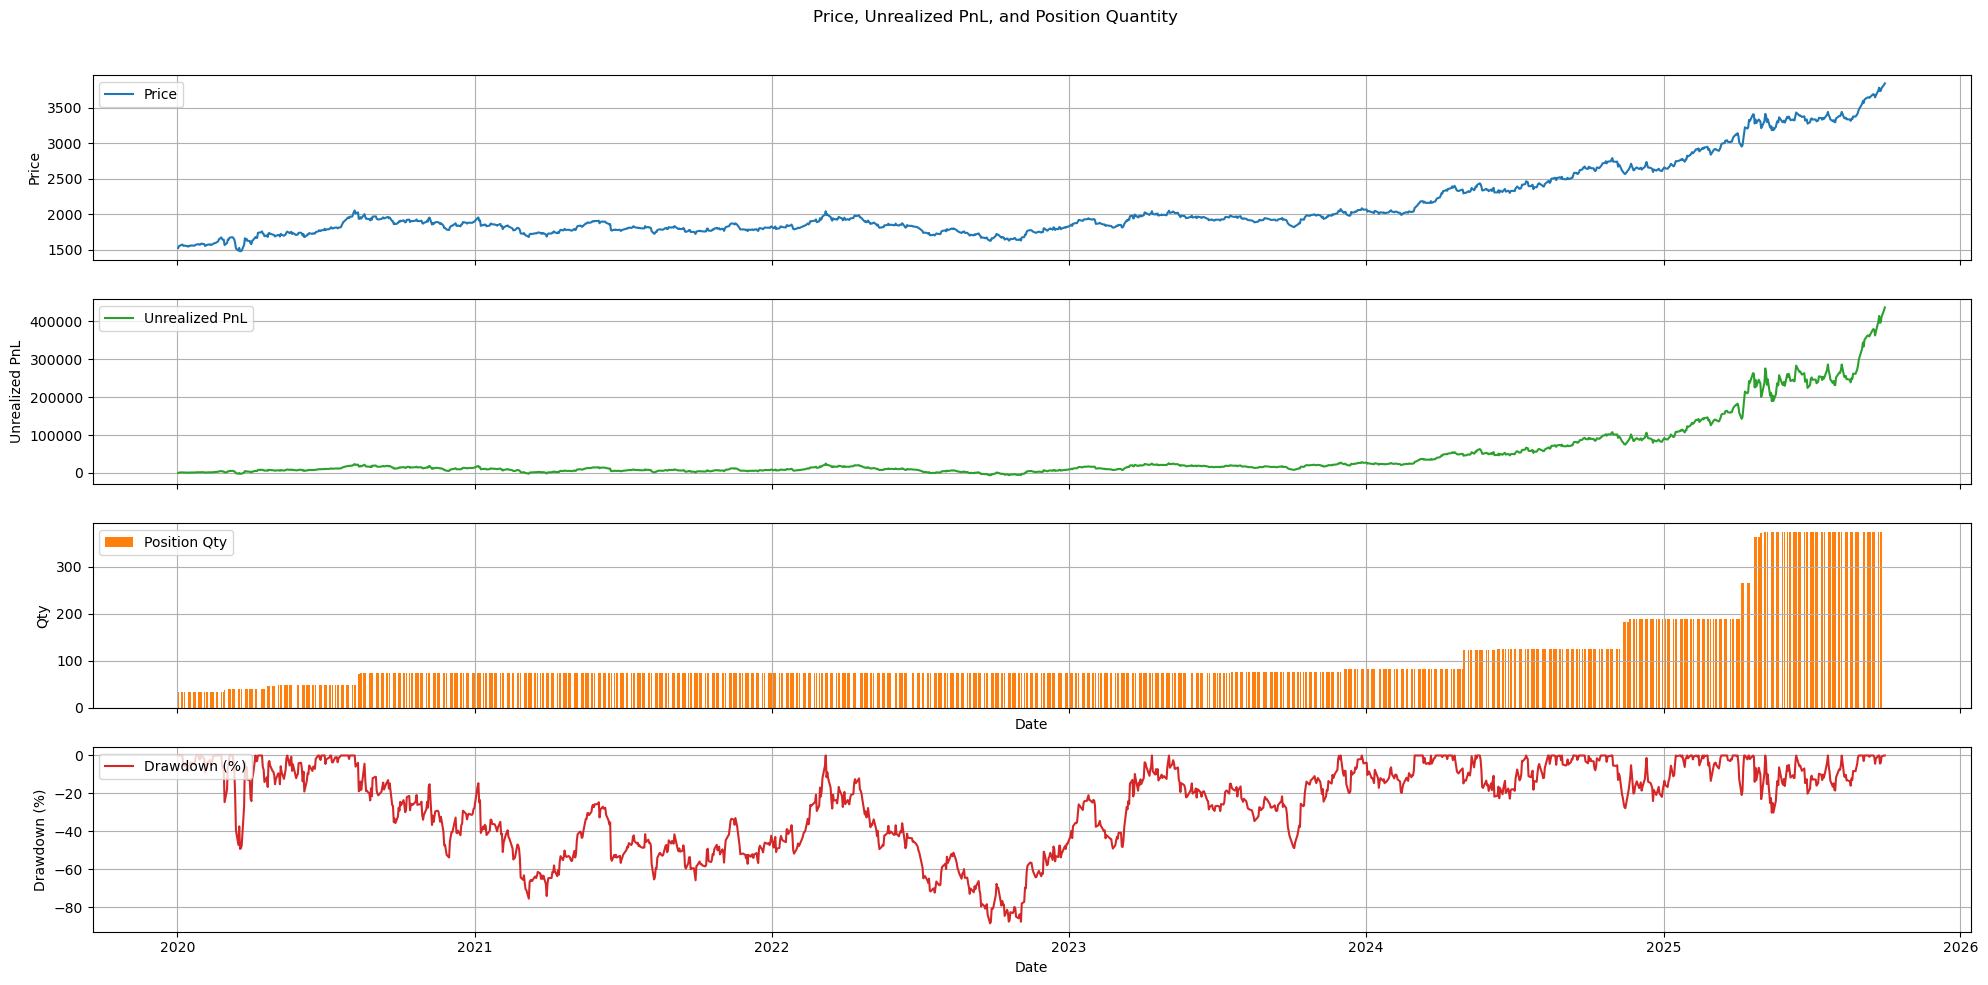

In [7]:
bt.plot_unrealized()